# NYC Taxi Duration Capstone

## Exploratory Data Analysis<a id='Exploratory Data Analysis'></a>
* [Objectives](#Objectives)
* [Further Data Cleaning](#0.0_Further_Data_Cleaning)
    * [Initial Summaries](#1._Intitial_Summaries)
        * [Summary statistics for relevant features](#1.1_Summary_statistics_for_relevant_features)
        * [Sampling](#1.2_Sampling)
    * [Geospatial visualization](#2._Geospatial_visualization)
        * [Creating Distance features](#2.2_Creating_Distance_features)
    * [Distribution of Features](#3._Distribution_of_Features)
        * [Correlation Matrix](#3.1_Correlation_Matrix)
        * [Visualization for Categorical Data](#3.2_Visualization_for_Categorical_Data)
    * [Trip Duration and Time](#4._Trip_Duration_and_Time)
        * [Stationarity](#4.1_Stationarity)
        * [Log Transform of Trip Duration](#4.2_Log_Transform_of_Trip_Duration)
    * [Understanding High Dimensional Data with PCA](#5._Understanding_High_Dimensional_Data_with_PCA)
        * [Validation](#5.1_Validation)
        * [PCA Transformation](#5.2_PCA_Transformation)
* [Citations](#Citations)

# Objectives

In this step, we want to investigate our wrangled data. Each feature and their relationship with other features in our dataset will be summarized with appropriate statistical techniques, such as correlation. Given that the data has geospatial information (latitude, longitude), we can also explore geographic patterns within the data. 

In [86]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
%matplotlib inline

nyc_taxi = pd.read_csv('../data/nyc_taxi_clean.csv')
conditions_data = pd.read_csv('../data/conditions.csv')


pd.set_option('display.max_columns', None)

pd.options.display.float_format = '{:.2f}'.format

# Show plots inline
%matplotlib inline

In [88]:
nyc_taxi.info()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456544 entries, 0 to 1456543
Data columns (total 31 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1456544 non-null  int64  
 1   id                     1456544 non-null  object 
 2   Vendor                 1456544 non-null  int64  
 3   pickup_datetime        1456544 non-null  object 
 4   dropoff_datetime       1456544 non-null  object 
 5   passenger_count        1456544 non-null  int64  
 6   pickup_longitude       1456544 non-null  float64
 7   pickup_latitude        1456544 non-null  float64
 8   dropoff_longitude      1456544 non-null  float64
 9   dropoff_latitude       1456544 non-null  float64
 10  StoreAndForward        1456544 non-null  bool   
 11  trip_duration          1456544 non-null  float64
 12  Temperature_C          1456544 non-null  float64
 13  Temperature_F          1456544 non-null  float64
 14  Dewpoint_C        

What can we say about our dataset? It is **multivariate, time series, geospatial**. 

**1.** Since the data is **multivariate**, there are multiple variables available to explore patterns. We can use 

- histograms + kernel density estimation to check the distribution of variables.

- PCA for continuous variables.

- Visualization for categorical variables.

**2.** Since we are dealing with **geospatial** data, we will want to

- Create a distance feature to analyze distance with the other features.

- Map the data to known geography.

**3.** Since we are dealing with **time series**, we will need to 

- Parse datetime variables.

- Check for Stationarity.

We are also dealing with a large and fully populated dataset, where the number of observations total to 1,465,544 trips. 

To clarify, the **goal of EDA is to explore data relationships of all features and understand how features compare to response variable.**

Our first task is to build data profiles and tables for each feature. We can use inferential statistics to accomplish this. 

### 0.0 Further Data Cleaning

Currently, we have 30 features. However, several of these features are the same - and only differ in the metric used to measure the feature. These identical features should have a Pearson correlation of 1. To verify this, let's find the correlation between identical features. These features are: 

- Temperature (Celsius and Fahrenheit)

- Dewpoint (Celsius and Fahrenheit)

- Wind Speed (kph and mph)

- Visibility (km and miles)

- Pressure (mbar and inHg)

In [89]:
corr, _ = pearsonr(nyc_taxi.Temperature_C, nyc_taxi.Temperature_F)
print('Pearson correlation between Temperature metrics is: %.2f' % corr)
corr2, _ = pearsonr(nyc_taxi.Dewpoint_C, nyc_taxi.Dewpoint_F)
print('Pearson correlation between Dewpoint metrics is: %.2f' % corr2)
corr3, _ = pearsonr(nyc_taxi.WindSpeed_kph, nyc_taxi.WindSpeed_mph)
print('Pearson correlation between Wind Speed metrics is: %.2f' % corr3)
corr4, _ = pearsonr(nyc_taxi.Visibility_km, nyc_taxi.Visibility_miles)
print('Pearson correlation between Visibility metrics is: %.2f' % corr4)
corr5, _ = pearsonr(nyc_taxi.Pressure_mbar, nyc_taxi.Pressure_inHg)
print('Pearson correlation between Pressure metrics is: %.2f' % corr5)

Pearson correlation between Temperature metrics is: 1.00
Pearson correlation between Dewpoint metrics is: 1.00
Pearson correlation between Wind Speed metrics is: 1.00
Pearson correlation between Visibility metrics is: 1.00
Pearson correlation between Pressure metrics is: 1.00


Great - we can confidently drop one of the metric systems from the dataset, knowing full well that the features are multicollinear. Let's drop the imperial system measurements and keep the metric system.

In [90]:
nyc_taxi.drop(columns = ['Temperature_F', 
                                    'Dewpoint_F', 
                                    'WindSpeed_mph',
                                   'Visibility_miles',
                                   'Pressure_inHg'],
                        axis = 1,
                        inplace = True)

In [91]:
nyc_taxi.shape
nyc_taxi.head(5)

,Unnamed: 0,id,Vendor,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,StoreAndForward,trip_duration,Temperature_C,Dewpoint_C,Humidity,WindSpeed_kph,WindDirection_degrees,WindDirection_desc,Visibility_km,Pressure_mbar,Conditions,icon,fog,rain,snow,Month
0,0,id0190469,2,2016-01-01 00:00:17,2016-01-01 00:14:26,5,-73.98,40.72,-73.94,40.83,False,14.15,5.60,-3.30,53.00,7.40,0,Variable,16.10,1018.50,Overcast,cloudy,False,False,False,1
1,1,id1665586,1,2016-01-01 00:00:53,2016-01-01 00:22:27,1,-73.99,40.75,-73.96,40.72,False,21.57,5.60,-3.30,53.00,7.40,0,Variable,16.10,1018.50,Overcast,cloudy,False,False,False,1
2,2,id1210365,2,2016-01-01 00:01:01,2016-01-01 00:07:49,5,-73.97,40.80,-73.95,40.82,False,6.80,5.60,-3.30,53.00,7.40,0,Variable,16.10,1018.50,Overcast,cloudy,False,False,False,1
3,3,id3888279,1,2016-01-01 00:01:14,2016-01-01 00:05:54,1,-73.98,40.75,-73.99,40.75,False,4.67,5.60,-3.30,53.00,7.40,0,Variable,16.10,1018.50,Overcast,cloudy,False,False,False,1
4,4,id0924227,1,2016-01-01 00:01:20,2016-01-01 00:13:36,1,-73.97,40.76,-73.99,40.74,False,12.27,5.60,-3.30,53.00,7.40,0,Variable,16.10,1018.50,Overcast,cloudy,False,False,False,1


We now have 26 features and over a million observations for each feature. Let's look at the data type breakdown for each feature again. 

In [92]:
nyc_taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456544 entries, 0 to 1456543
Data columns (total 26 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1456544 non-null  int64  
 1   id                     1456544 non-null  object 
 2   Vendor                 1456544 non-null  int64  
 3   pickup_datetime        1456544 non-null  object 
 4   dropoff_datetime       1456544 non-null  object 
 5   passenger_count        1456544 non-null  int64  
 6   pickup_longitude       1456544 non-null  float64
 7   pickup_latitude        1456544 non-null  float64
 8   dropoff_longitude      1456544 non-null  float64
 9   dropoff_latitude       1456544 non-null  float64
 10  StoreAndForward        1456544 non-null  bool   
 11  trip_duration          1456544 non-null  float64
 12  Temperature_C          1456544 non-null  float64
 13  Dewpoint_C             1456544 non-null  float64
 14  Humidity          

One feature can be ignored - the unnamed 0 column. Many of the features are continuous variables. However, there are several categorical variables. 

- **fog**, **rain**, **snow** and **StoreAndForward** are booleans.

- **Month**, **Vendor**, **passenger_count** and **WindDirection_degrees** are categorical types

Our dataset has a mix of categorical variables and continuous variables. It is probably not feasible to do PCA since many components are categorical and the results would not make much sense. However, we could use PCA to reduce the dimensions of factor levels by examining the relationship between factor levels and the continuous variables in the dataset. We can look at the **Conditions** feature as a loose proxy for the Weather data and find out which conditions are the most influential.

For now, let's drop the unnamed column. 

In [93]:
nyc_taxi.drop(columns = ['Unnamed: 0'],
              axis = 1, 
              inplace = True)

In [94]:
nyc_taxi.shape

(1456544, 25)

## 1. Initial Summaries

### 1.1 Summary statistics for relevant features

We will take a univariate non-graphical view of the dataset and find its statistical parameters. 

In [95]:
nyc_taxi_continuous = nyc_taxi.select_dtypes(include ='float64')
nyc_taxi_continuous.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,Temperature_C,Dewpoint_C,Humidity,WindSpeed_kph,Visibility_km,Pressure_mbar
count,1456544.00,1456544.00,1456544.00,1456544.00,1456544.00,1456544.00,1456544.00,1456544.00,1456544.00,1456544.00,1456544.00
mean,-73.97,40.75,-73.97,40.75,13.95,12.61,2.87,54.72,9.33,14.68,1016.63
std,0.07,0.03,0.07,0.04,10.99,9.26,10.52,18.95,6.34,3.09,7.31
min,-121.93,34.36,-121.93,32.18,0.02,-18.30,-28.30,9.00,0.00,0.40,989.50
25%,-73.99,40.74,-73.99,40.74,6.62,5.60,-4.40,41.00,5.60,14.50,1011.80
50%,-73.98,40.75,-73.98,40.75,11.03,12.20,3.30,52.00,9.30,16.10,1016.63
75%,-73.97,40.77,-73.96,40.77,17.88,20.60,12.20,68.00,13.00,16.10,1021.20
max,-61.34,51.88,-61.34,43.92,200.85,32.80,22.80,100.00,120.40,16.10,1036.80


#### Check discrepancies

We should check for the max and min of latitude and longitude. Then, we can set limits that are appropriate to Yellow Cab serviceable area. 

We also looked at the max of trip duration time during Data Wrangling. The min is very suspicious. 

In [96]:
longitude_lim = [-74.18, -73.78]
latitude_lim = [40.67, 40.87]
# Set the geographic limits
nyc_taxi = nyc_taxi[
    (nyc_taxi['pickup_longitude'].between(longitude_lim[0],
                                                longitude_lim[1], 
                                                inclusive = True))
]
nyc_taxi = nyc_taxi[(nyc_taxi['dropoff_longitude'].between(longitude_lim[0],
                                                 longitude_lim[1], 
                                                 inclusive = True))
]
nyc_taxi = nyc_taxi[(nyc_taxi['pickup_latitude'].between(latitude_lim[0],
                                               latitude_lim[1], 
                                               inclusive = True))
]
nyc_taxi = nyc_taxi[(nyc_taxi['dropoff_latitude'].between(latitude_lim[0],
                                                latitude_lim[1], 
                                                inclusive = True))
                   ]

In [97]:
nyc_taxi['trip_duration'].sort_values(ascending=True).head(3000)

424642    0.02
815384    0.02
17946     0.02
99626     0.02
126077    0.02
          ... 
1103133   0.37
1346530   0.37
44417     0.37
991999    0.37
1185751   0.37
Name: trip_duration, Length: 3000, dtype: float64

There are a number of trips with .02 trip duration. We have a lot of data and it is obvious that .02 minutes is very short for a taxicab ride, so we can drop these values. .37 is more feasible. In the future, we can use outlier techniques.

We can check the distribution of trip duration and if the density is normal or lognormal, we can use the standard Tukey's rule - or omit values more than 1.5 times the IQR (The difference between the 75th and 25th percentile). 

### 1.2 Sampling

We cannot complete this project feasibly without sampling. Let's look at 10,000 samples from our population of 1.5 million. 

In [98]:
# sample method
sampled = 10000
nyc_taxi_trimmed = nyc_taxi.sample(sampled)
nyc_taxi_trimmed.shape

(10000, 25)

We should also create a trimmed sample for only continuous variables, if we want to use PCA. 

In [99]:
nyc_taxi_ctrimmed = nyc_taxi_continuous.sample(sampled)
nyc_taxi_ctrimmed.shape

(10000, 11)

## 2. Geospatial visualization

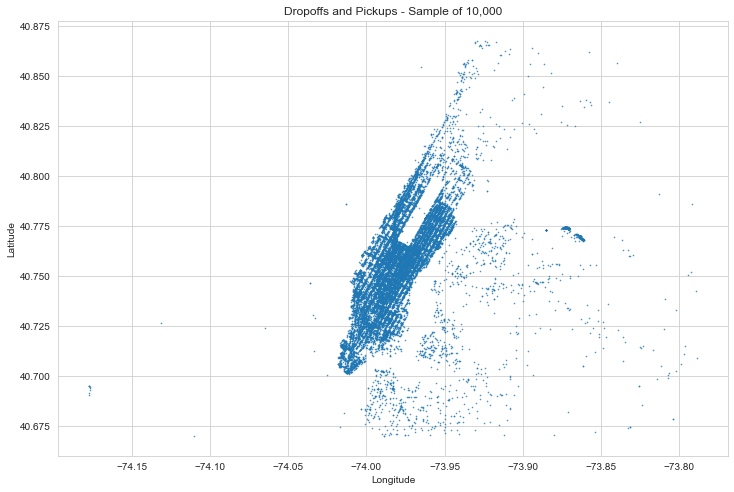

In [100]:
plt.figure(figsize=(12,8))


longitude = list(nyc_taxi_trimmed.pickup_longitude) + list(nyc_taxi_trimmed.dropoff_longitude)
latitude = list(nyc_taxi_trimmed.pickup_latitude) + list(nyc_taxi_trimmed.dropoff_latitude)
data = pd.DataFrame({'Latitude': latitude, 'Longitude': longitude})
sns.set_style("whitegrid")
ax = sns.regplot(
    x="Longitude", 
    y="Latitude", 
    data=data, 
    scatter=True, 
    fit_reg=False, 
    scatter_kws={"s": 0.35}
)
plt.title('Dropoffs and Pickups - Sample of 10,000')
plt.show()

We can clearly see Manhattan, Brooklyn, Queens and the Bronx! As we can see, **dropoffs** and **pickups** occur primarily in Manhattan, which significantly less travel in the Bronx, Brooklyn and Queens. 

### 2.1 Creating Distance Features

Given geospatial data and the objective for trip duration prediction, one would naturally assume that the distance between pickup and dropoff could be a possibly significant variable. 

There are several distance formulas that we can use. 

1. **Manhattan Distance** - Determines distance by creating a right angle when parallel to destination. Given that our data is from New York City and primarily Manhattan,  Manhattan Distance may be the most accurate distance measure to the routes travelled by taxis. 

2. **Haversine Distance** - Determines distance between two points on a sphere. 

In [101]:
def haversine_vectorize(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    lon_diff = lon2 - lon1
    lat_diff = lat2 - lat1
    haver_formula = np.sin(lat_diff/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(lon_diff/2.0)**2
    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367* dist 
    return km

In [102]:
def manhattan_vectorize(lon1, lat1, lon2, lat2):
    first = haversine_vectorize(lon1, lat1, lon2, lat1)
    scnd = haversine_vectorize(lon1, lat1, lon1, lat2)
    return first + scnd

In [103]:
nyc_taxi['haversine_distance'] = haversine_vectorize(nyc_taxi['pickup_longitude'],
                    nyc_taxi['pickup_latitude'],
                    nyc_taxi['dropoff_longitude'],
                   nyc_taxi['dropoff_latitude'])

In [104]:
nyc_taxi['manhattan_distance'] = manhattan_vectorize(nyc_taxi['pickup_longitude'],
                    nyc_taxi['pickup_latitude'],
                    nyc_taxi['dropoff_longitude'],
                   nyc_taxi['dropoff_latitude'])

In [105]:
nyc_taxi.head(3)

,id,Vendor,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,StoreAndForward,trip_duration,Temperature_C,Dewpoint_C,Humidity,WindSpeed_kph,WindDirection_degrees,WindDirection_desc,Visibility_km,Pressure_mbar,Conditions,icon,fog,rain,snow,Month,haversine_distance,manhattan_distance
0,id0190469,2,2016-01-01 00:00:17,2016-01-01 00:14:26,5,-73.98,40.72,-73.94,40.83,False,14.15,5.60,-3.30,53.00,7.40,0,Variable,16.10,1018.50,Overcast,cloudy,False,False,False,1,12.75,15.84
1,id1665586,1,2016-01-01 00:00:53,2016-01-01 00:22:27,1,-73.99,40.75,-73.96,40.72,False,21.57,5.60,-3.30,53.00,7.40,0,Variable,16.10,1018.50,Overcast,cloudy,False,False,False,1,4.01,5.57
2,id1210365,2,2016-01-01 00:01:01,2016-01-01 00:07:49,5,-73.97,40.80,-73.95,40.82,False,6.80,5.60,-3.30,53.00,7.40,0,Variable,16.10,1018.50,Overcast,cloudy,False,False,False,1,2.17,3.07


## 3. Distribution of Features

We need to set the data to the new nyc_taxi since we added longitude and latitude limits. 

In [106]:
# Reset data after cutoffs
nyc_taxi_continuous = nyc_taxi.select_dtypes(include ='float64')
nyc_taxi_continuous['WindDirection_degrees'] = nyc_taxi['WindDirection_degrees']

<ipython-input-106-1dad920d8845>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyc_taxi_continuous['WindDirection_degrees'] = nyc_taxi['WindDirection_degrees']


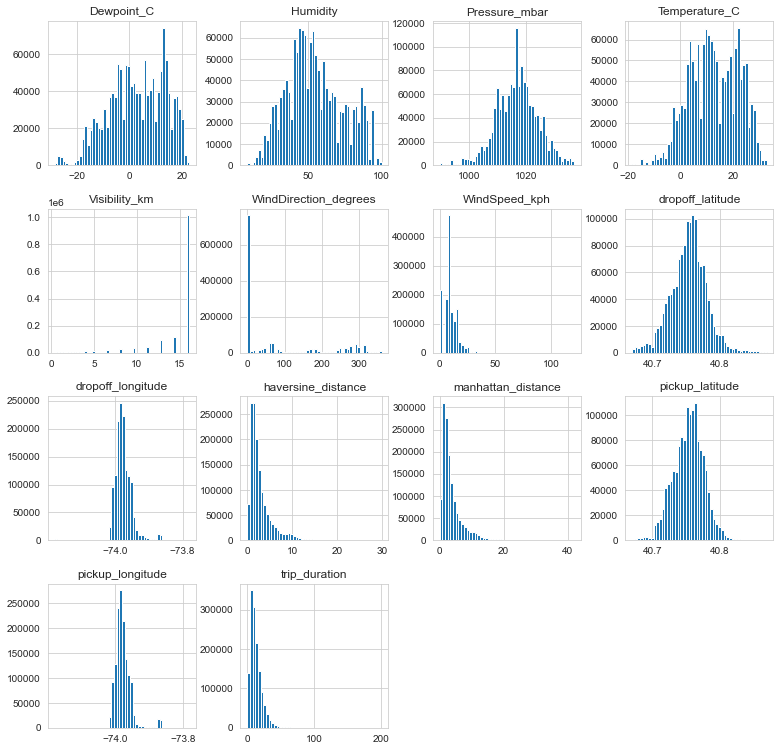

In [107]:
hist = nyc_taxi_continuous.hist(bins = 50, 
                          figsize = (13,13))

Here are some takes:
    
- Longitude and latitude data seem to have a Normal distribution. This implies that **most of the pickups and dropoffs occur only in Manhattan (and in the same location).**

- Pressure seems to have a Normal distribution. 

- Visibility and Windspeed are skewed left and right respectively, meaning that it is **rare for less than clear visibility** and **rare for wind speed above 10 kph**.

- **Trip Duration and the Distance features** seems to have a log-normal distribution. *More on this later*

- Temperature seems to be **trimodal**. This checks out, since the data is from January to June, or the dead of Winter to the beginning of Summer. The winter is frequently cold, the spring is usually temperate and the summer is very hot. There is probably very high correlation between datetime and temperature. 

- It doesn't seem like we can say much about Humidity or Dewpoint, but they are potentially Normal and Skewed Left. Dewpoint and Humidity are very much related to each other, and both are subject to changes in weather - which occur as the seasons change.  

Given that the **Temperature** distribution is **trimodal**, it may be helpful to create a **Season** variable - Winter, Spring and Summer. 

In [108]:
nyc_taxi['Season'] = [month%12 // 3 + 1 for month in nyc_taxi.Month]

We can further observe how the variables are correlated with each other with a correlation matrix and a pairplot

### 3.1 Correlation matrix

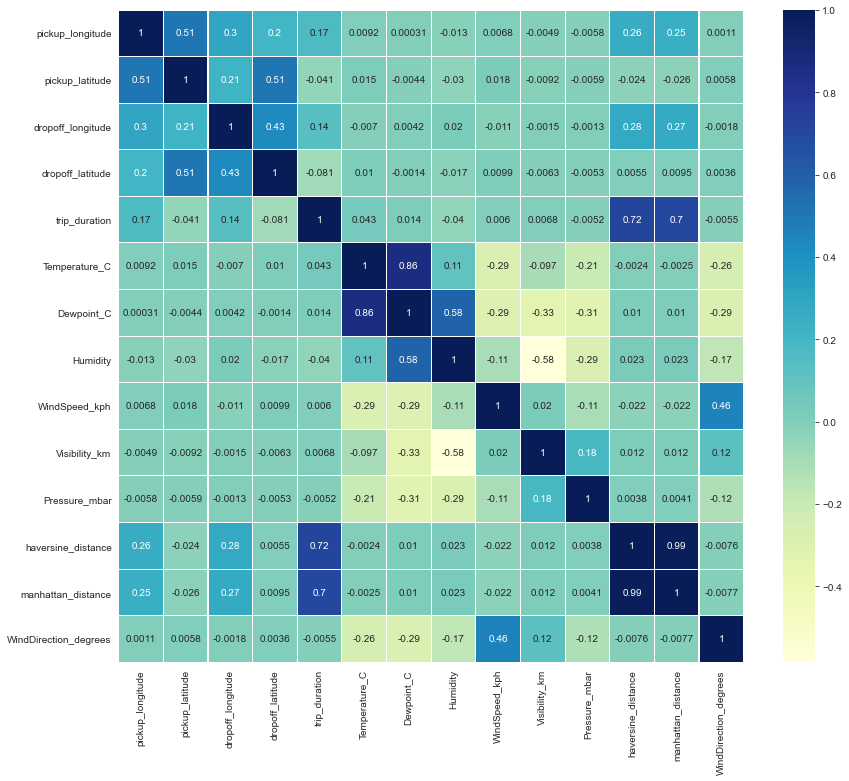

In [109]:
plt.figure(figsize=(14,12))
sns.heatmap(nyc_taxi_continuous.corr(),
            linewidths=.1,
            cmap="YlGnBu", 
            annot=True)
plt.yticks(rotation=0);

Unfortunately, **our definition for correlation is quite limited**. The correlation matrix only measures the Pearson correlation, which is the scaled covariance and therefore, can only detect linear relationships from Normal distributions. It is limiting to think that only linear relationships exist between variables. A **pairplot** would help visualize the variable distributions. 

Given that only **pickup, dropoff, and pressure** data is **normally distributed**, we can say that: 

- **pickup latitude** and **pickup longitude** are moderately positively correlated, meaning that, as the latitude increases, the pickup longitude tends to increase moderately. **dropoff** coordinates are also weakly positively correlated. This could inform us about the flow of yellow taxi traffic and specifically, that yellow taxis tend to travel northwest. Since we are working with geospatial data, it is far more efficient and informative to plot the latitude and longitude on map and create a **distance** feature. 

- **Wind Speed and Direction** are moderately positively correlated. 

In [110]:
def scatterplots(columns, ncol=None, figsize=(15, 8)):
    if ncol is None:
        ncol = len(columns)
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        ax.scatter(x = col, 
                   y = 'trip_duration', 
                   data=nyc_taxi_continuous, 
                   alpha=0.5)
        ax.set(xlabel=col, 
               ylabel='Trip Duration')
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

In [111]:
features = [n for n in nyc_taxi_continuous if n not in ['trip_duration']]

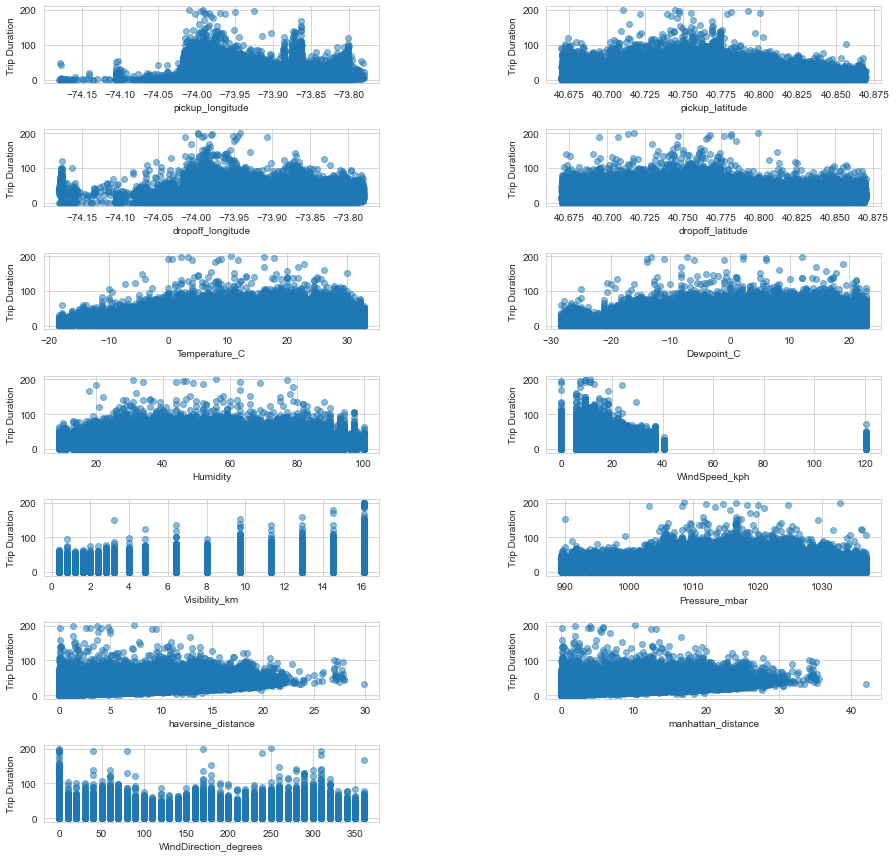

In [112]:
scatterplots(features, ncol=2, figsize = (15,15))

Given the sheer amount of data, it comes as no surprise that there is a lot of density in each of the scatterplots.

- The  **visibility** and **Wind Direction** features are not continuous and have defined levels.

- The spread for **Pickup Longitude and latitude** suggest that some pickup locations lend themselves to faster trip durations. These locations are North of Downtown - this is obvious given Downtown Manhattan's traffic density in the latitude-longitude mapping in section 2. 

- **Low Temperature** lends itself to faster trips. **Distance** has a variable relationship with Trip duration up until 10+, where the expected trip duration narrows and is less susceptible to greater traffic. This suggests that typical long distance trips could use less traffic dense routes, such as trips to Long Island or to the Airport. 

### 3.2 Visualization for Categorical Data

Let's now observe patterns within the categorical data.  

In [113]:
nyc_taxi_cat = nyc_taxi.select_dtypes(exclude = 'float64')
nyc_taxi_cat.shape

(1392773, 15)

In [114]:
nyc_taxi_cat.drop(columns = ['id', 
                                'pickup_datetime',
                                'dropoff_datetime'],
                                axis = 1, 
                                inplace = True)

C:\Users\User\Documents\Temp\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


The total ratio of rain to no rain at pickup for the entire six month period is 0.043


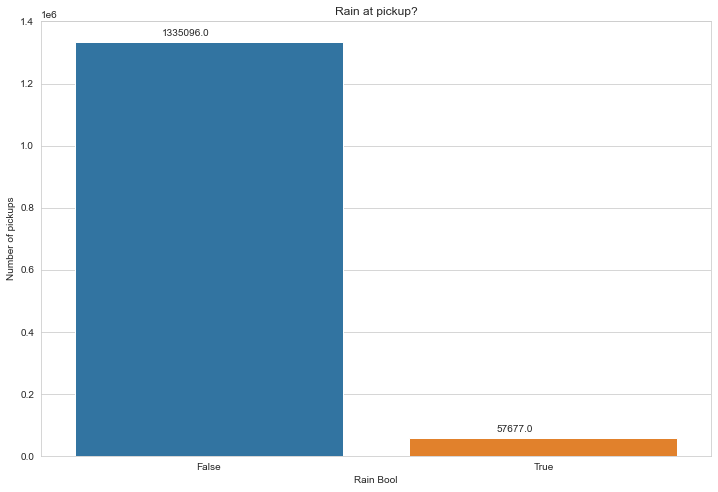

In [115]:
# Weather conditions
plt.figure(figsize=(12,8))
ax = sns.countplot(nyc_taxi_cat['rain'])
plt.title('Rain at pickup?')
plt.xlabel('Rain Bool')
plt.ylabel('Number of pickups')

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.26, p.get_height()+20000))
    
print('The total ratio of rain to no rain at pickup for the entire six month period is '+'{:.3f}'.format(57677.0/1335096.0))

The majority of pickups did **not** deal with rain - only 4% of the pickups dealt with rain. Of course, this varies with the time of year, since there is seasonality in weather data. 

The total ratio of Snow to No Snow at pickup for the entire six month period is 0.008


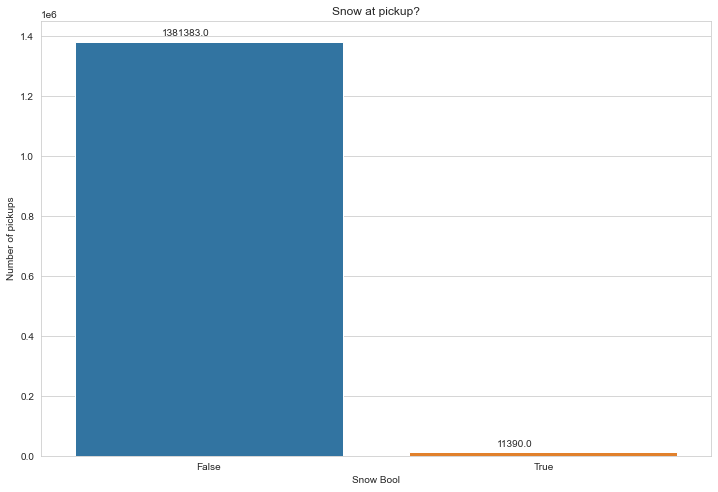

In [116]:
# Weather conditions
plt.figure(figsize=(12,8))
ax = sns.countplot(nyc_taxi_cat['snow'])
plt.title('Snow at pickup?')
plt.xlabel('Snow Bool')
plt.ylabel('Number of pickups')

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.26, p.get_height()+20000))
    
print('The total ratio of Snow to No Snow at pickup for the entire six month period is '+'{:.3f}'.format(11390.0/1381383.0))

The total ratio of Fog to No Fog at pickup for the entire six month period is 0.002


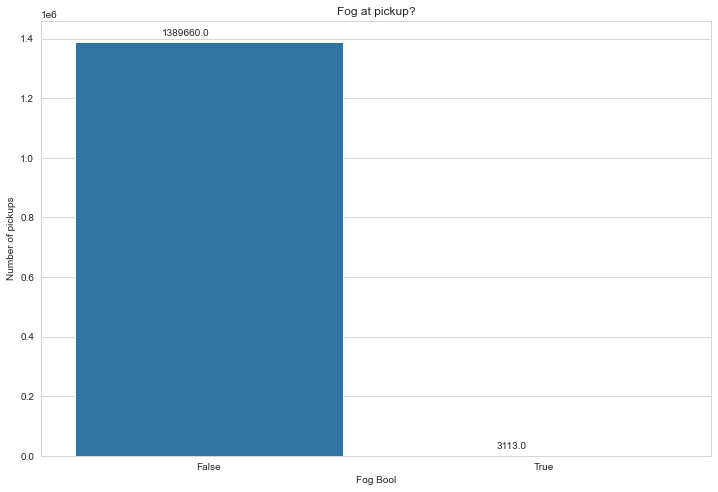

In [117]:
# Weather conditions
plt.figure(figsize=(12,8))
ax = sns.countplot(nyc_taxi_cat['fog'])
plt.title('Fog at pickup?')
plt.xlabel('Fog Bool')
plt.ylabel('Number of pickups')

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.26, p.get_height()+20000))
    
print('The total ratio of Fog to No Fog at pickup for the entire six month period is '+'{:.3f}'.format(3113.0/1389660.0))

**Fog, Snow and Rain** do not appear frequently in the dataset relative to the rest of the data available. However, we can reason that these attributes are greatly influenced by the time of year. 

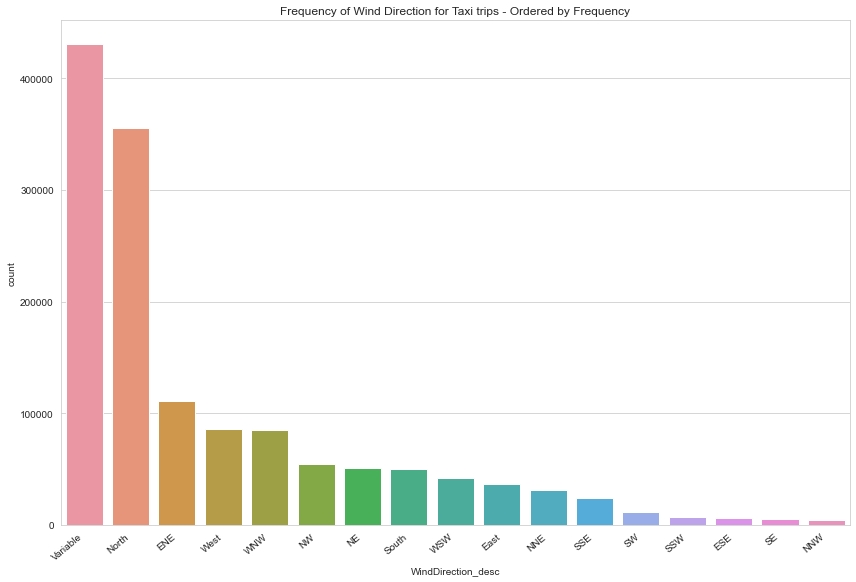

In [118]:
plt.figure(figsize=(12,8))
ax = sns.countplot(nyc_taxi_cat['WindDirection_desc'],
                  order = nyc_taxi_cat['WindDirection_desc'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Frequency of Wind Direction for Taxi trips - Ordered by Frequency')
plt.show()

For a majority of the trips, the Wind Direction is **variable**, meaning that there is no clear direction. When there is a clear Wind Direction, it is likely **North**, meaning the wind blows towards the Bronx and Upper State New York. 

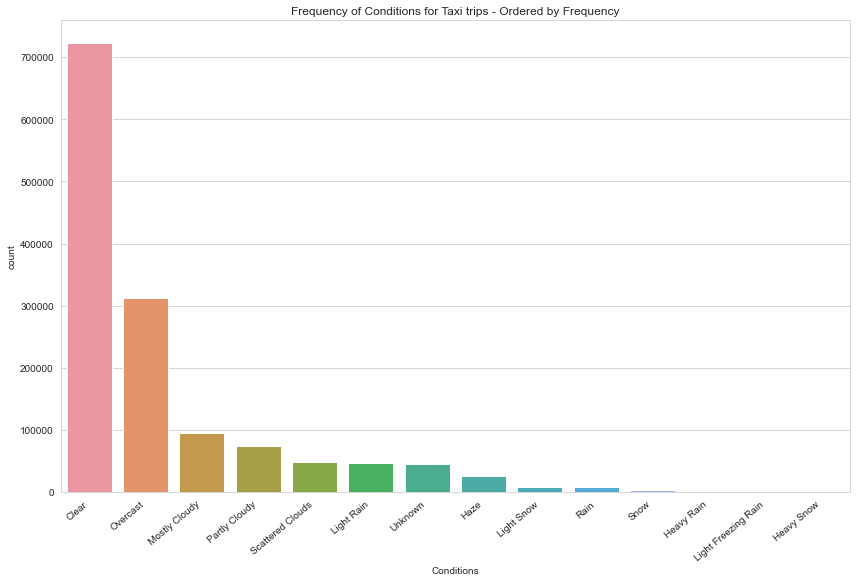

In [119]:
plt.figure(figsize=(12,8))
ax = sns.countplot(nyc_taxi_cat['Conditions'],
                  order = nyc_taxi_cat['Conditions'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Frequency of Conditions for Taxi trips - Ordered by Frequency')
plt.show()

Much of the trips occured during **Clear** conditions, and were likely otherwise **Cloudy** conditions.

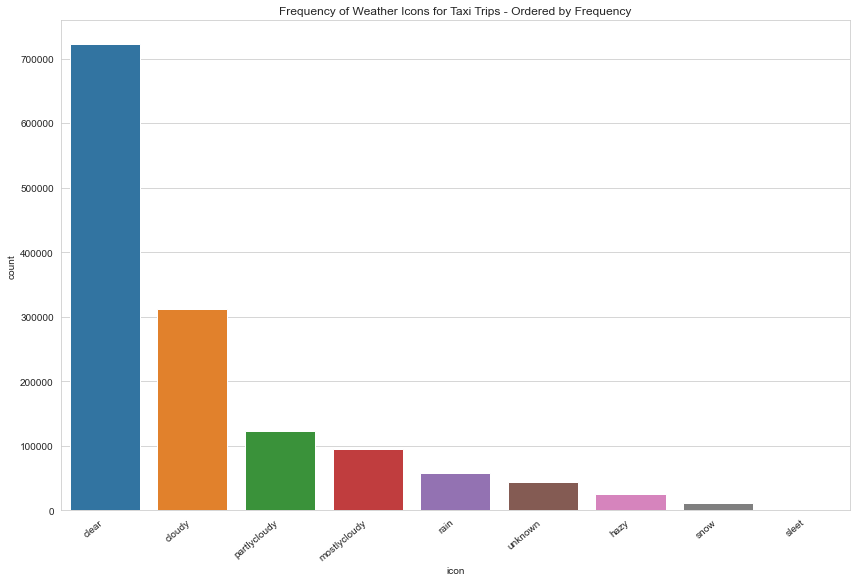

In [120]:
plt.figure(figsize=(12,8))
ax = sns.countplot(nyc_taxi_cat['icon'], 
                  order = nyc_taxi_cat['icon'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.title('Frequency of Weather Icons for Taxi Trips - Ordered by Frequency')
plt.show()

# Use the same color for bars
# ONLY use colors to convey information

This overlaps with the Conditions feature, so we will ignore the icons feature moving forward. 

Many of the Weather variables are related to the Season of the data object. 

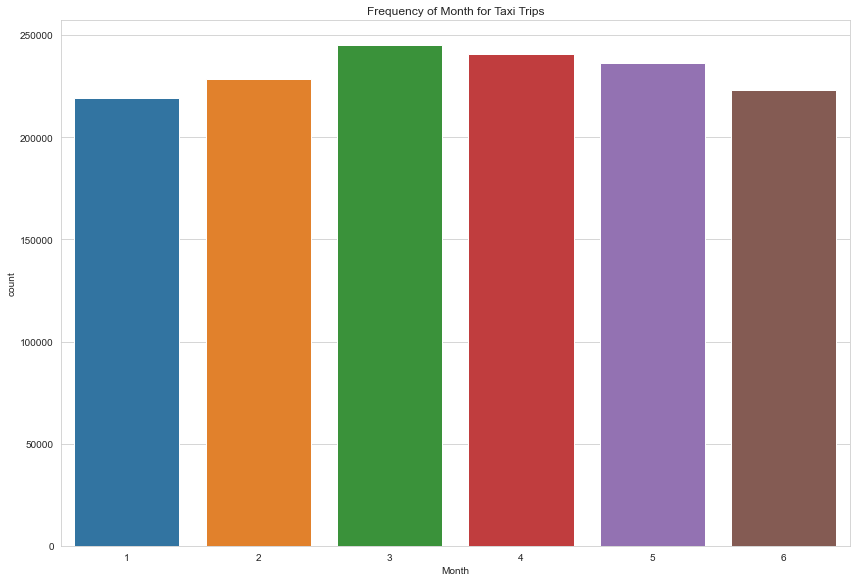

In [121]:
plt.figure(figsize=(12,8))
sns.countplot(nyc_taxi_cat['Month'])
plt.tight_layout()
plt.title('Frequency of Month for Taxi Trips')
plt.show()

The difference in days between months does not seem to matter for frequency of trips. **February** has two less days than **January**, yet had trips. The spring season, **March** to **May**, seems to have the greatest frequency in total trips throughout the given time period.

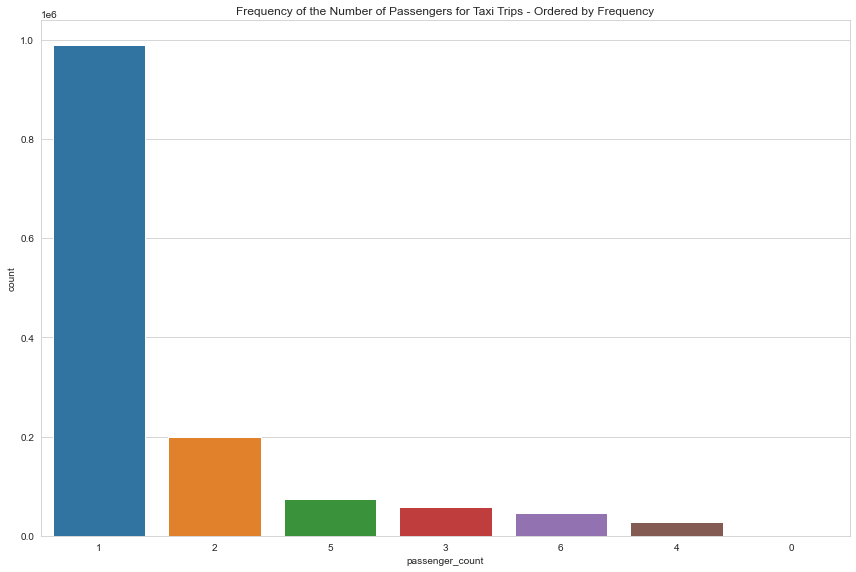

In [122]:
plt.figure(figsize=(12,8))
sns.countplot(nyc_taxi_cat['passenger_count'], 
             order = nyc_taxi_cat['passenger_count'].value_counts().index)
plt.tight_layout()
plt.title('Frequency of the Number of Passengers for Taxi Trips - Ordered by Frequency')
plt.show()

Most of the trips picked up one passenger. Many trips picked up two passengers. It was less likely that trip involved 3+ passengers. 

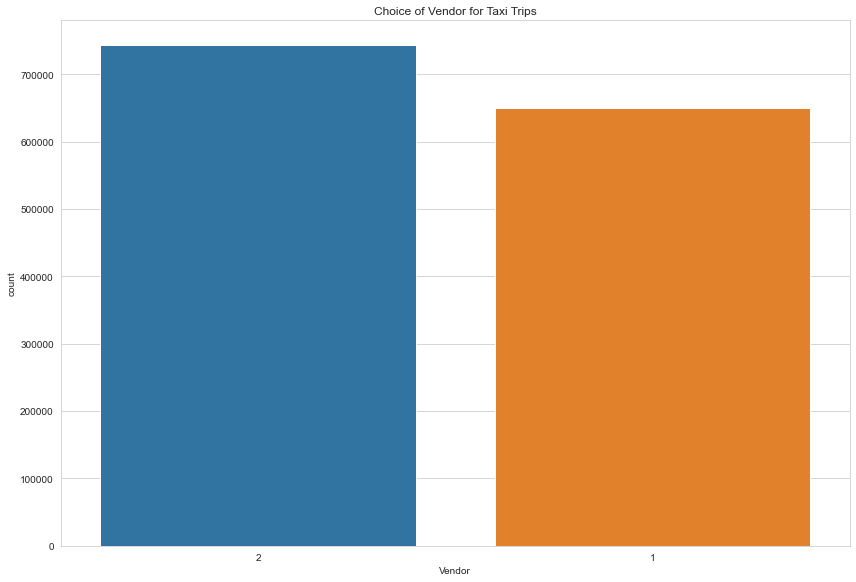

In [123]:
plt.figure(figsize=(12,8))
sns.countplot(nyc_taxi_cat['Vendor'],
             order = nyc_taxi_cat['Vendor'].value_counts().index)
plt.tight_layout()
plt.title('Choice of Vendor for Taxi Trips')
plt.show()

Vendor 2, **Verifone LLC**, was more popular than Vendor 1, **Creative Mobile Technologies**, for the given time period.

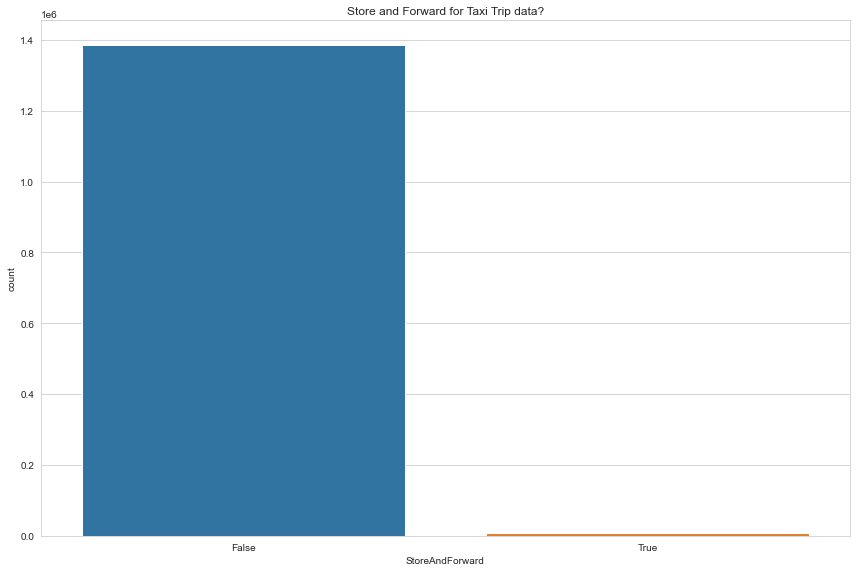

In [124]:
plt.figure(figsize=(12,8))
sns.countplot(nyc_taxi_cat['StoreAndForward'])
plt.tight_layout()
plt.title('Store and Forward for Taxi Trip data?')
plt.show()

Some takeaways: 

- StoreAndForward is very rare.

- A majority of the weather is clear with variable wind direction. If not variable, then most likely the wind blows North

- Rain, fog, and snow are all relatively rare. 

- The trip is usually for one passenger. There are slightly more trips in March than in any other month. However, the difference is slight. 

There are currently many features that are related to each other. To create an interpretable model, we will need to get rid of multicollinearity. 

## 4. Trip duration and Time

#### Parsing more datetime variables (day, hour)

In [125]:
import datetime as dt
nyc_taxi_dates = pd.to_datetime(nyc_taxi['pickup_datetime'])

In [126]:
dayofweek = nyc_taxi_dates.dt.day_name()
dayz = nyc_taxi_dates.dt.day
hourz = nyc_taxi_dates.dt.hour
nyc_taxi_trimmed['dayofweek'] = dayofweek
nyc_taxi_trimmed['day'] = dayz
nyc_taxi_trimmed['hour'] = hourz

Text(0, 0.5, 'Number of Trips')

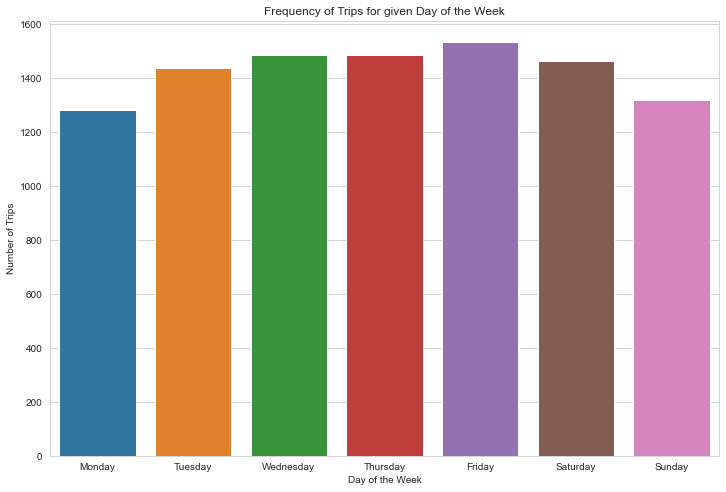

In [127]:
plt.figure(figsize=(12,8))
sns.countplot(nyc_taxi_trimmed['dayofweek'],
              order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])
plt.title('Frequency of Trips for given Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')

More trips occur on **Thursday, Friday and Saturday** than other days. There are more trips on Tuesday and Wednesday than on Sunday and Monday.

Text(0, 0.5, 'Number of Trips')

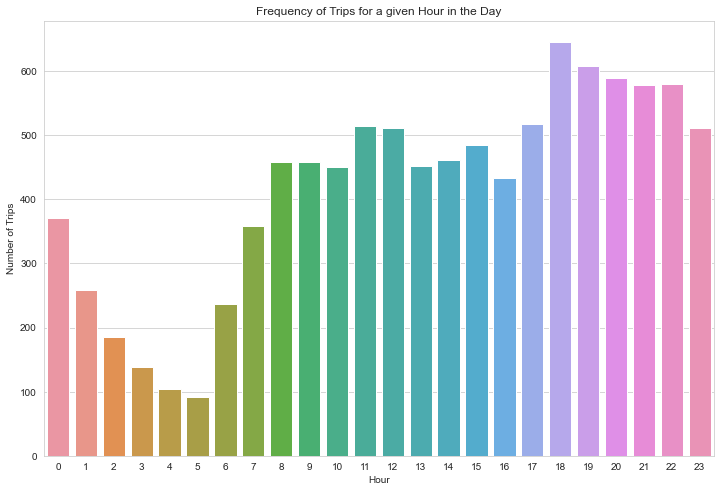

In [128]:
plt.figure(figsize=(12,8))
sns.countplot(nyc_taxi_trimmed['hour'])
plt.title('Frequency of Trips for a given Hour in the Day')
plt.xlabel('Hour')
plt.ylabel('Number of Trips')

Most trips occur at 18:00 to 22:00 (6 pm to 10 pm). There is greater Taxi traffic density at the end of the work day than the beginning of the work day. 

Text(0, 0.5, 'Number of Trips')

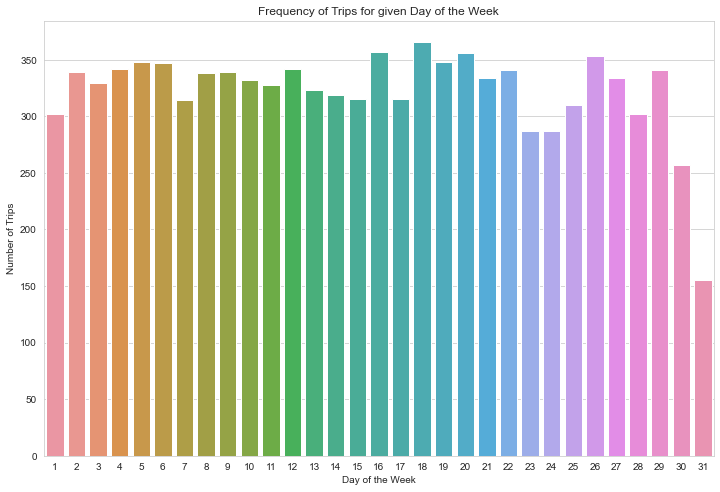

In [129]:
plt.figure(figsize=(12,8))
sns.countplot(nyc_taxi_trimmed['day'])
plt.title('Frequency of Trips for given Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')

Certain days, such as the 4th, the 8th, the 12th, the 14th, the 19th, the 25th and the 27th have more trips than the rest of the month. One reason for this could be that these specific days of the month are related to high traffic days of the week. 

However, the number of trips is similar throughout the month. The data for the end of the Month is not entirely accurate (There is no 30th of February and there is only a 31st for three months out of the six month period for data collection).

### 4.1. Stationarity

Given that our data is time variant, we should check for **Stationarity**. A Stationary time series have constant means, variances and autocorrelation (or similarity between the data and a lagged version of the data. This measures to what degree the data fluctuates over time). 

First, let's check out how Total Trip and Trip duration fare over time. 

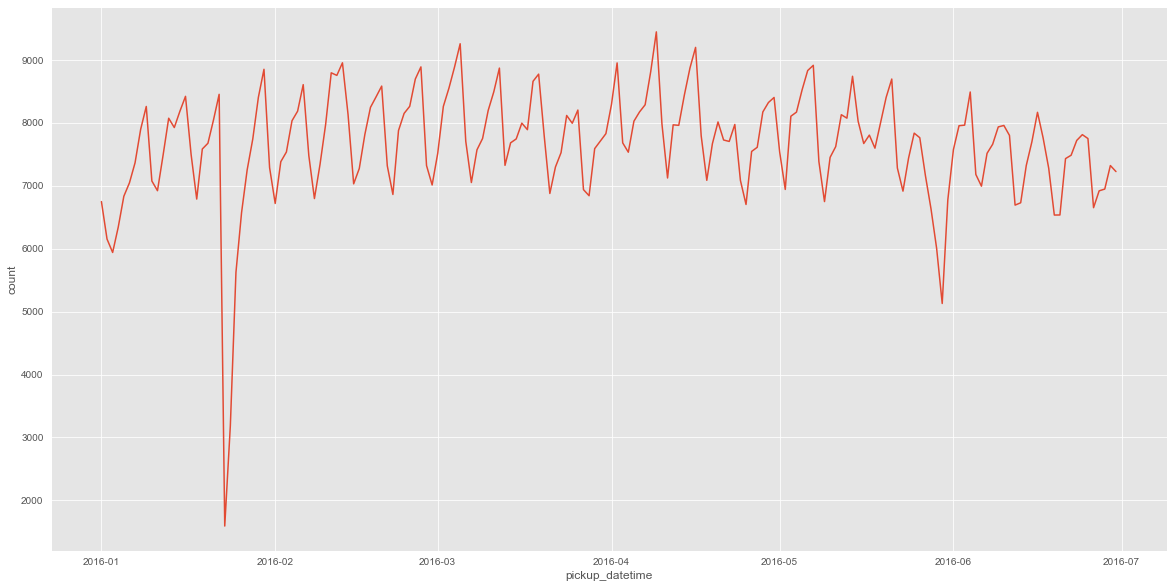

In [193]:
date = nyc_taxi_dates.dt.date
datum = pd.DataFrame(date)
datum['count'] = datum.groupby('pickup_datetime')['pickup_datetime'].transform('count')
datum = datum.drop_duplicates(subset = ['pickup_datetime'])
sns.lineplot(x = 'pickup_datetime', 
            y = 'count',
            data = datum)

Interesting! There was some sort of drop in Taxi services in late January and late May. Let's see what it was:

In [205]:
print(datum[datum['count'] == datum['count'].min()])

       pickup_datetime  count
170204      2016-01-23   1592


This should explain it - The [2016 January blizzard](https://en.wikipedia.org/wiki/January_2016_United_States_blizzard) was historic in its scope and intensity, meaning that the exceptional weather affected traffic. 

### 4.2. Log Transform of Trip Duration

We can recall from the **trip duration** histogram plot that the data was heavily skewed left. We can log transform the data to make it Normal, so that our statistical analyses can be valid. 

In [46]:
# Create data distribution code
def prob_dist(data):
    x = np.array(data)
    # set the number of bins using Freedman - Diaconis rule
    # n_bins = twice cube root of number of observations
    n = len(x)
    n_bins = 100
    
    fig = plt.figure()
    
    # histogram
    ax1 = fig.add_axes([0.1, 0.3, 0.8, 0.6])
    ax1 = plt.hist(x, bins=n_bins, alpha=0.7)
    plt.grid(alpha=.5)
    
    # boxplot
    ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.2])
    ax2 = plt.boxplot(x, vert=False, widths=0.5)
    plt.grid(alpha=.5)
    plt.show()

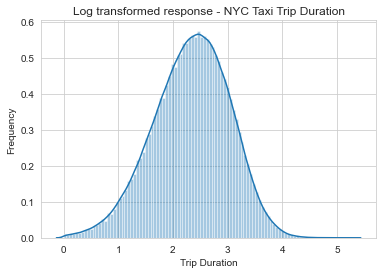

In [47]:
logtrip = np.log(nyc_taxi.trip_duration[nyc_taxi['trip_duration'] >= 1])
ax = sns.distplot(logtrip,
                 bins = 100, 
                 kde = True)
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')
plt.title('Log transformed response - NYC Taxi Trip Duration')
plt.show()

The data seems to be approximately normal, and it doesn't seem to need any sort of reshaping. Trip duration, our response for our future model, is now normal. 

In [48]:
import statsmodels.api as sm
import pylab as py

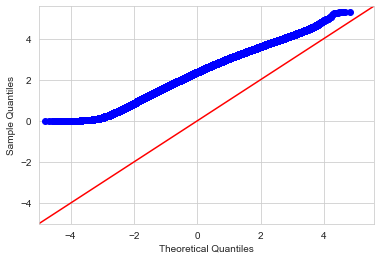

In [49]:
sm.qqplot(logtrip, line ='45')
py.show()

A qq-plot assumes that the mean is zero and that the distribution to the left and right is normally distributed. 

Since we are looking at a log transformed variable, there will be no values below zero. Thus, we can't use the $x = y$ line for reference.

What this does tell us is that the slope of our plot, although not parallel with $x = y$, is consistent and less steep. Our response is shaped like a bell curve but has fatter tails (more equally distributed than a Standard Normal distribution). 

## 5. Understanding High Dimensional Data with PCA

Which Weather Conditions account for the most variation in the dataset? For this question and with continuous variables, it may be prudent to use PCA. 

Principle Components Analysis (PCA) finds a linear combinations of the features that are uncorrelated with one another and order them by the amount of variance they explain. In our case, the features in question are the Weather Conditions, and an uncorrelated feature means that there is no distinguishable trend between each feature. Ordering components by the variance each feature explains can help reduce high dimension data and prevent overfitting - but how does PCA do this? 

Much like covariance, PCA is susceptible to metric bias if the data is not scaled, since we are looking for relative data spread between features. The data is scaled to so that the spread within each feature is comparable.   

PCA takes data from the first two components, its average, and creates a new origin at the average. It then finds the line of best fit between the data, which, similar to Linear Regression, is the minimum sum of the squared distances between the point and the line. This also finds the maximum of the sum of squared distances between the origin and the data object of the first two components. The weights of the best fit line for each component create the Eigenvalue for the components, and the line of best fit is the Eigenvector. 

The slope of the eigenvector is the ratio of variance explained by the first component to the second component. is the for the first component is known as the loading score. The distance of the eigenvector from origin to data object is scaled to 1, and the 

To ensure that the features are uncorrelated, the second line for mapping the second component is orthogonal to the Eigenvector, or perpendicular. The transformation is known as a **change of basis**. A **basis** is the space created by two vectors that are independent of each other. Since the vectors are orthogonal, any linear combination of the two vectors will exist within the space. A change of basis occurs when the bounds of the vector space are changed. This process repeats for the next components, except that each Eigenvector must be uncorrelated to the other principal components. 

The transformation is then applied to the data to create the derived features, and the scores of these features are then analyzed to evaluate the important of a certain dimension. In our case , we will be looking at Weather Conditions.

To first scale the data, we will need to make sure the data available is numeric - otherwise it is of no use. We should set the factor we are interested in, Conditions, as an index.

In [50]:
conditions_data_scale = conditions_data.set_index('Conditions')
conditions_data_ind = conditions_data_scale.index
conditions_data_scale.head().reset_index()

,Conditions,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,StoreAndForward,trip_duration,Temperature_C,Temperature_F,Dewpoint_C,Dewpoint_F,Humidity,WindSpeed_kph,WindSpeed_mph,WindDirection_degrees,Visibility_km,Visibility_miles,Pressure_mbar,Pressure_inHg,fog,rain,snow,Month
0,Clear,1.67,-73.97,40.75,-73.97,40.75,0.01,13.98,12.44,54.39,0.37,32.67,45.98,8.94,5.56,90.30,15.67,9.73,1019.12,30.10,0.00,0.00,0.00,3.63
1,Haze,1.65,-73.97,40.75,-73.97,40.75,0.01,14.49,18.78,65.81,13.41,56.14,72.10,6.95,4.33,62.57,9.11,5.65,1014.12,29.95,0.00,0.00,0.00,3.65
2,Heavy Rain,1.70,-73.98,40.75,-73.97,40.75,0.01,13.14,20.16,68.30,18.60,65.48,90.62,8.62,5.37,78.90,1.55,0.98,1011.47,29.87,0.22,1.00,0.00,3.94
3,Heavy Snow,1.59,-73.98,40.75,-73.97,40.75,0.00,14.10,-3.83,25.14,-6.20,20.82,83.67,27.03,16.81,51.27,0.40,0.20,1009.35,29.81,0.61,0.00,1.00,1.00
4,Light Freezing Rain,1.60,-73.98,40.75,-73.98,40.75,0.02,11.26,0.15,32.27,-1.58,29.12,88.26,11.22,6.98,60.33,4.69,2.93,1023.80,30.24,0.00,1.00,0.00,2.00


We know that not all of our data types are numeric, though they do yield a number in the output. For example, month is an integer from 1 to 6. Even if days were used as a substitute, the variable would still be discrete. Let's check the number of unique values per column for this dataset. 

In [51]:
conditions_data_scale.drop(columns = ['Temperature_F', 
                                    'Dewpoint_F', 
                                    'WindSpeed_mph',
                                   'Visibility_miles',
                                   'Pressure_inHg',
                                            'fog',
                                            'rain',
                                            'snow',
                                            'Month'],
                        axis = 1,
                        inplace = True)

In [52]:
conditions_data_columns = conditions_data_scale.columns

In [53]:
conditions_data_scale.nunique()

passenger_count          14
pickup_longitude         14
pickup_latitude          14
dropoff_longitude        14
dropoff_latitude         14
StoreAndForward          14
trip_duration            14
Temperature_C            14
Dewpoint_C               14
Humidity                 14
WindSpeed_kph            14
WindDirection_degrees    14
Visibility_km            14
Pressure_mbar            14
dtype: int64

We can now scale the numeric data. 

In [54]:
conditions_data_scale = scale(conditions_data_scale)

In [55]:
conditions_scaled_df = pd.DataFrame(data=conditions_data_scale, 
                                    columns=conditions_data_columns)
conditions_scaled_df.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,StoreAndForward,trip_duration,Temperature_C,Dewpoint_C,Humidity,WindSpeed_kph,WindDirection_degrees,Visibility_km,Pressure_mbar
0,0.38,0.14,-0.03,-0.36,-0.15,-0.25,0.26,0.32,-0.58,-1.68,-0.50,1.15,1.13,1.15
1,-0.22,0.15,1.48,-0.62,1.81,-0.20,0.80,1.13,1.32,0.04,-0.92,-0.11,0.07,-0.17
2,1.68,-1.81,-1.81,-0.25,-1.73,-0.09,-0.63,1.31,2.07,1.25,-0.56,0.63,-1.16,-0.87
3,-2.30,-1.69,1.56,2.46,-1.57,-2.04,0.39,-1.76,-1.53,0.79,3.32,-0.62,-1.34,-1.44
4,-2.03,-1.61,-2.02,-1.72,-0.62,2.93,-2.61,-1.25,-0.86,1.10,-0.02,-0.21,-0.65,2.40


### 5.1 Validation

To verify that the data was scaled to a Standard Normal distribution (mean is 0, variance is 1), we can look at its mean and spread, where the degrees of freedom are 0 to avoid bias correction.

In [56]:
conditions_scaled_df.mean()

passenger_count          0.00
pickup_longitude        -0.00
pickup_latitude         -0.00
dropoff_longitude        0.00
dropoff_latitude         0.00
StoreAndForward          0.00
trip_duration           -0.00
Temperature_C           -0.00
Dewpoint_C              -0.00
Humidity                -0.00
WindSpeed_kph           -0.00
WindDirection_degrees   -0.00
Visibility_km           -0.00
Pressure_mbar            0.00
dtype: float64

In [57]:
conditions_scaled_df.std(ddof=0)

passenger_count         1.00
pickup_longitude        1.00
pickup_latitude         1.00
dropoff_longitude       1.00
dropoff_latitude        1.00
StoreAndForward         1.00
trip_duration           1.00
Temperature_C           1.00
Dewpoint_C              1.00
Humidity                1.00
WindSpeed_kph           1.00
WindDirection_degrees   1.00
Visibility_km           1.00
Pressure_mbar           1.00
dtype: float64

### 5.2 PCA Transformation

We can now use the PCA Transformation using the Standard Normal data.

In [58]:
conditions_pca = PCA().fit(conditions_data_scale)

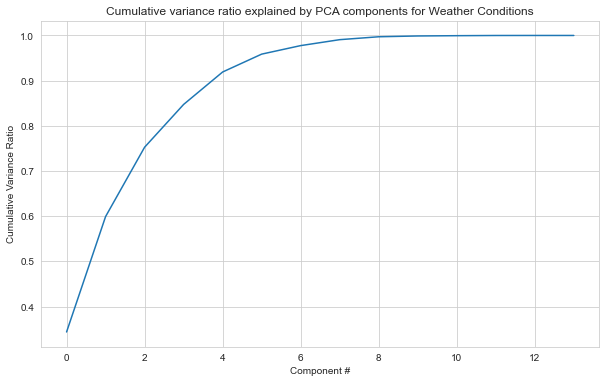

In [59]:
plt.subplots(figsize=(10, 6))
plt.plot(conditions_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative Variance Ratio')
plt.title('Cumulative variance ratio explained by PCA components for Weather Conditions');

Nearly 90% of the data can be explained by the first four Components. Nearly all of the Variance was explained by the first eight Components.

In [60]:
conditions_pca_x = conditions_pca.transform(conditions_data_scale)
conditions_pca_x.shape

(14, 14)

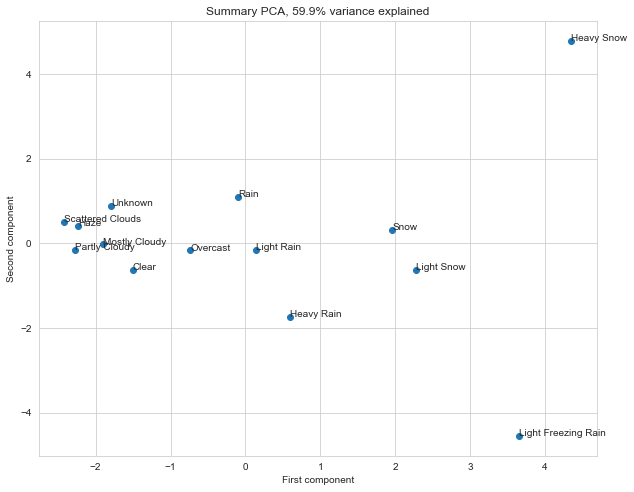

In [61]:
x = conditions_pca_x[:, 0]
y = conditions_pca_x[:, 1]
conditions = conditions_data_ind
pc_var = 100 * conditions_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f'Summary PCA, {pc_var:.1f}% variance explained')
for c, x, y in zip(conditions, x, y):
    plt.annotate(c, (x, y))

The components that explained the most variance were **Light Freezing Rain** and **Heavy Snow**. The first component shows that the variation in Scattered Clouds/Clear/Overcast Conditions to Raining/Snowing conditions. The second components plots Heavy Snow and Light Freezing Rain as opposing and similarly strong influences.

### Citations: 

**1.** A tutorial on Principle Component Analysis. (https://www.cs.princeton.edu/picasso/mats/PCA-Tutorial-Intuition_jp.pdf)

**2.** Finding optimal bin size for histogram graphs (https://www.answerminer.com/blog/binning-guide-ideal-histogram)

**3.** Log transformation advice (https://online.stat.psu.edu/stat462/node/156/)

**4.** Information on the Haversine distance (https://plus.maths.org/content/lost-lovely-haversine)